In [1]:
import financeMacroFactors as fM
import json
import logging
import itertools as it
from pprint import pprint
import numpy as np
import scipy.interpolate

from datetime import datetime as dt
from datetime import timedelta as tDel

import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'

In [2]:
logger = logging.getLogger('financeMacroFactors')
logger.setLevel(logging.ERROR)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

# General Characteristics of the PE Value

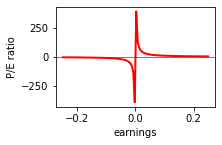

In [3]:
N = 100

p = np.ones(N)
e = np.linspace(0.25, -0.25, N)

plt.figure(figsize=(3,3/1.6), facecolor='white')
ax = plt.axes([0.25, 0.25, 0.74, 0.74])

plt.axhline(0, color='k', lw=0.5)
plt.plot(e, p/e, lw=2, color='red')
plt.xlabel('earnings')
plt.ylabel('P/E ratio')
plt.savefig('img/PEchar.png', dpi=300)
plt.show()
plt.close()

# Get the PE value for the Market

## Stock Data

The stock data is obtained from Yahoo! Finance. However to reduce the bandwidth requirements, it is important to cache this data as much as possible. In the code below, the stock data has been cached in the folder `stockData`  as JSON file.

[['Date', 'Open', 'High', 'Low', 'Close*', 'Adj. close**', 'Volume'],
 ['01 Jul 2020', 203.14, 216.38, 197.51, 205.01, 205.01, 770306200.0],
 ['01 Jun 2020', 182.54, 204.4, 181.35, 203.51, 203.51, 764905600.0]]


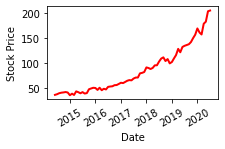

In [4]:
msftStock = json.load(open('stockData/MSFT.json'))
pprint(msftStock[:3])

datesP, _, _, _, _, pricesP, volP = zip(*msftStock[1:])
datesP = [ dt.strptime( d.replace('-', ' '), "%d %b %Y") for d in datesP]


plt.figure(figsize=(3,3/1.6), facecolor='white')
ax = plt.axes([0.2, 0.3, 0.79, 0.69])

plt.plot( datesP, pricesP, lw=2, color='red' )
plt.xticks(rotation=30)

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.savefig('img/msft_stock_price.png', dpi=300)

plt.show()
plt.close()

## EPS Data

The Fundamental data is downloaded from MarketWatch. Note that fundamental data is only updated once a quarter. Hence, it is important to also cache this informaiton. Currently, this data is kept in a folder called `data` and is currently loaded from there.

The EPS data is obtained directly form the fundamental data. Here, a simple assumption is made - the yearly earnings is approximately equal to four times the quarterly earnings. Hence, earnings are calculated in this way. Of course, if we had more quarterly data than the last 5, it may be possible to use more advanced algorithms for this approximation.

[(datetime.datetime(2016, 6, 30, 0, 0), 2.1),
 (datetime.datetime(2017, 6, 30, 0, 0), 3.25),
 (datetime.datetime(2018, 6, 30, 0, 0), 2.13)]


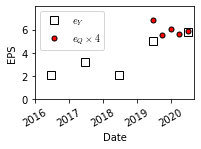

In [5]:
msft = json.load(open('data/MSFT.json'))
epsYr = fM.companies.extractYearlyData( msft['IncomeStatement'], 'EPS (Diluted)' )
epsQt = fM.companies.extractQuarterlyData( msft['IncomeStatementQuarter'], 'EPS (Diluted)'  )
epsQt = [(d,e*4) for d,e in epsQt]

data  = sorted(epsYr+epsQt)

pprint(data[:3])

plt.figure(figsize=(3,3/1.6), facecolor='white')
ax = plt.axes([0.15, 0.3, 0.74, 0.69])

dates, eps = zip(*epsYr)
plt.plot(dates, eps, 's', mfc='None', mec='k', ms=8, label=r'$e_Y$')

dates, eps = zip(*epsQt)
plt.plot(dates, eps, 'o', mfc='red', mec='k', ms=5, label=r'$e_Q \times 4$')


plt.xticks(
    [dt(2016,1,1), dt(2017,1,1), dt(2018,1,1), dt(2019,1,1), dt(2020,1,1)],
    ['2016', '2017', '2018', '2019', '2020'],
    rotation=30)
plt.yticks([0,2,4,6])

plt.ylim([0,8])

plt.xlabel('Date')
plt.ylabel('EPS')
plt.legend(loc='upper left', frameon=True)
plt.savefig('img/msft_EPS.png', dpi=300)

plt.show()
plt.close()

In [6]:
temp, *rest = zip(*msft['IncomeStatement'])
[v for v in msft['IncomeStatement'] if v[0]== 'Diluted Shares Outstanding']

[['Diluted Shares Outstanding',
  8010000000.0,
  7830000000.0,
  7790000000.0,
  7750000000.0,
  7680000000.0]]

In [7]:
[v for v in msft['IncomeStatementQuarter'] if v[0]== 'Diluted Shares Outstanding']

[['Diluted Shares Outstanding',
  7730000000.0,
  7710000000.0,
  7690000000.0,
  7680000000.0,
  7650000000.0]]

Notice that different companies report quarterly earnings on different months. For this reason, it would be useful to interpolate the EPS so that there is a value every month. This will significantly expedite calculations.

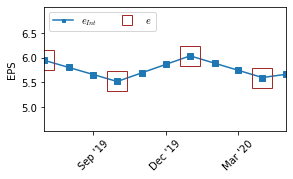

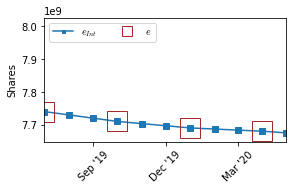

In [11]:
def interpolate(data, finalDate=None):
    
    #---------------------------------------------------------
    # The assumption here is that all the dates are 
    # such that they are on the first of the current
    # month. 
    #---------------------------------------------------------
    dates, eps = zip(*data)
    
    if finalDate is None:
        finalDate = dates[-1]
        
    y,m = finalDate.year, finalDate.month
    
    datesInterpolate = []
    for i in range(12):
        m = m-1
        if m == 0:
            m = 12
            y = y-1
        datesInterpolate.append( dt(y,m,1) )
        
    days    = [ (d-finalDate).days for d in dates ]
    daysInt = [ (d-finalDate).days for d in datesInterpolate]
    
    f = scipy.interpolate.interp1d(days, eps, fill_value='extrapolate')
    
    epsInterpolate = f( daysInt )
    
    return list(zip(datesInterpolate, epsInterpolate))


def reduceMean(data1):
    
    data1 = sorted(data1)
    
    data2 = []
    for k, v in it.groupby(data1, lambda m: m[0]):
        _, v = zip(*v)
        v = sum(v)/len(v)
        data2.append([k, v])
    
    return data2


# -----------------------------------------
# Calculate the interpolated monthly EPS
# -----------------------------------------
msft = json.load(open('fundData/MSFT.json'))
epsYr = fM.companies.extractYearlyData( msft['IncomeStatement'], 'EPS (Diluted)' )
epsQt = fM.companies.extractQuarterlyData( msft['IncomeStatementQuarter'], 'EPS (Diluted)'  )
epsQt = [(d,e*4) for d,e in epsQt]

data  = sorted(epsYr+epsQt)

data1 = [(m+tDel(1), n) for m,n in data]
data2 = reduceMean(data1)            
data3 = interpolate(data2)

# --------------------------------------------
# Calculate the interpolated monthly shares
# --------------------------------------------
sharesYr = fM.companies.extractYearlyData( msft['IncomeStatement'], 'Diluted Shares Outstanding' )
sharesQt = fM.companies.extractQuarterlyData( msft['IncomeStatementQuarter'], 'Diluted Shares Outstanding'  )


dataShares  = sorted(sharesYr+sharesQt)

dataShares1 = [(m+tDel(1), n) for m,n in dataShares]
dataShares2 = reduceMean(dataShares1)            
dataShares3 = interpolate(dataShares2)

# ---------------------------------------------
# -------- Plot the EPS -----------------------
# ---------------------------------------------


plt.figure(figsize=(4, 4/1.6), facecolor='white')
ax = plt.axes([0.15, 0.3, 0.84, 0.69])

dates, epsValue = zip(*data3)
plt.plot(dates, epsValue, 's-', label='$e_{Int}$')

dates1, epsValue1 = map(np.array, zip(*data2))
plt.plot(dates1, epsValue1, 's', mfc='None', mec='brown', ms=20, label='$e$')


plt.xlim([dates[-1], dates[1]])
plt.ylim([min(epsValue)-1, max(epsValue) + 1])

plt.xticks(
    [ dt(2019,9,1), dt(2019,12,1), dt(2020,3,1)],
    ["Sep '19", "Dec '19", "Mar '20"])
plt.yticks([5, 5.5, 6, 6.5])

plt.ylabel('EPS')
plt.legend(loc='upper left', ncol=2, markerscale=0.5)

plt.xticks(rotation=45)
plt.savefig('img/interpolateEPS.png', dpi=300)
plt.show()
plt.close()

# ---------------------------------------------
# -------- Plot the shares --------------------
# ---------------------------------------------

plt.figure(figsize=(4, 4/1.6), facecolor='white')
ax = plt.axes([0.15, 0.3, 0.84, 0.69])

dates, shareValue = zip(*dataShares3)
plt.plot(dates, shareValue, 's-', label='$e_{Int}$')

dates1, shareValue1 = map(np.array, zip(*dataShares2))
plt.plot(dates1, shareValue1, 's', mfc='None', mec='brown', ms=20, label='$e$')


plt.xlim([dates[-1], dates[1]])
#plt.ylim([min(epsValue)-1, max(epsValue) + 1])

plt.xticks(
    [ dt(2019,9,1), dt(2019,12,1), dt(2020,3,1)],
    ["Sep '19", "Dec '19", "Mar '20"])
#plt.yticks([5, 5.5, 6, 6.5])

plt.ylabel('Shares')
plt.legend(loc='upper left', ncol=2, markerscale=0.5)

plt.xticks(rotation=45)
plt.savefig('img/interpolateShares.png', dpi=300)
plt.show()
plt.close()



In [12]:
companies = ['MSFT', 'FB', 'AAP', 'LEN']
for c in companies:
    comp = json.load(open(f'data/{c}.json'))
    print( f'{c:>5s}:' , ', '.join(comp['IncomeStatementQuarter'][0][1:]))

 MSFT: 30-Jun-2019, 30-Sep-2019, 31-Dec-2019, 31-Mar-2020, 30-Jun-2020
   FB: 31-Mar-2019, 30-Jun-2019, 30-Sep-2019, 31-Dec-2019, 31-Mar-2020
  AAP: 30-Apr-2019, 31-Jul-2019, 30-Sep-2019, 31-Dec-2019, 30-Apr-2020
  LEN: 31-May-2019, 31-Aug-2019, 30-Nov-2019, 29-Feb-2020, 31-May-2020


## Calculate the PE value

Now that the interpolated EPS data is available, it is useful to calculate the PE value from these two values. This may be done with the following:


In [19]:
def getPEandVolume(ticker='msft', finalDate=None):
    
    logger = logging.getLogger('financeMacroFactors.getPEandVolume')
    
    try:
    
        # ==================================================
        # ==   Get Fundamental Data                       ==
        # ==================================================
        fundamentals = json.load(open(f'fundData/{ticker.upper()}.json'))
        epsYr = fM.companies.extractYearlyData( fundamentals['IncomeStatement'], 'EPS (Diluted)' )
        epsQt = fM.companies.extractQuarterlyData( fundamentals['IncomeStatementQuarter'], 'EPS (Diluted)'  )
        epsQt = [(d,e*4) for d,e in epsQt]

        eps = sorted(epsYr+epsQt)
        eps = reduceMean( eps )

        # --------------------------------------------------------
        # Remember that stock data is present of the first
        # of the month, while the fundamental data is typically
        # available at the end of the month
        # --------------------------------------------------------
        eps = [(m+tDel(1), n) for m,n in eps]
        eps = interpolate(eps, finalDate=finalDate)
        dates, _ = zip(*eps)
        epsDict = { d:e for d, e in eps }
        
        # ==================================================
        # ==   Get # shares diluted                       ==
        # ==================================================
        
        sharesYr = fM.companies.extractYearlyData( fundamentals['IncomeStatement'], 
                                                  'Diluted Shares Outstanding' )
        sharesQt = fM.companies.extractQuarterlyData( fundamentals['IncomeStatementQuarter'], 
                                                     'Diluted Shares Outstanding'  )
        
        shares = sorted(sharesYr + sharesQt)
        shares = reduceMean( shares )

        # --------------------------------------------------------
        # Remember that stock data is present of the first
        # of the month, while the fundamental data is typically
        # available at the end of the month
        # --------------------------------------------------------
        shares = [(m+tDel(1), n) for m,n in shares]
        shares = interpolate(shares, finalDate=finalDate)
        dates, _ = zip(*shares)
        sharesDict = { d:e for d, e in shares }
        

        # ==================================================
        # ==   Get Pricing Data                           ==
        # ==================================================
        pricing = json.load(open(f'stockData/{ticker.upper()}.json'))
        datesP, _, _, _, _, pricesP, _ = zip(*pricing[1:])
        datesP = [ dt.strptime( d.replace('-', ' '), "%d %b %Y") for d in datesP]
        
        # ==================================================
        # ==   Get PE Ratio                               ==
        # ==================================================
        result = [(d, p/epsDict[d], p, sharesDict[d])  for d, p in zip(datesP, pricesP) if d in dates ]
        return result

    except Exception as e:
        logger.error(f'Unable to generate PE data for [{ticker}]: {e}')
        return None
    
    return

getPEandVolume()

[(datetime.datetime(2020, 6, 1, 0, 0),
  35.49139517056343,
  203.51,
  7669945054.945055),
 (datetime.datetime(2020, 5, 1, 0, 0),
  32.25240496508922,
  182.74,
  7675054945.054945),
 (datetime.datetime(2020, 4, 1, 0, 0),
  31.912500000000005,
  178.71,
  7680000000.0),
 (datetime.datetime(2020, 3, 1, 0, 0),
  27.351827077440564,
  157.27,
  7683406593.406593),
 (datetime.datetime(2020, 2, 1, 0, 0),
  27.35432835820896,
  161.12,
  7686593406.593407),
 (datetime.datetime(2020, 1, 1, 0, 0),
  28.028145695364238,
  169.29,
  7690000000.0),
 (datetime.datetime(2019, 12, 1, 0, 0),
  26.7409741270665,
  156.83,
  7696739130.434783),
 (datetime.datetime(2019, 11, 1, 0, 0),
  26.34491182533018,
  150.04,
  7703260869.565217),
 (datetime.datetime(2019, 10, 1, 0, 0),
  25.742753623188406,
  142.1,
  7710000000.0),
 (datetime.datetime(2019, 9, 1, 0, 0),
  24.345354687560015,
  137.8,
  7719782608.695652),
 (datetime.datetime(2019, 8, 1, 0, 0),
  23.458647742805255,
  136.18,
  7729891304.347826

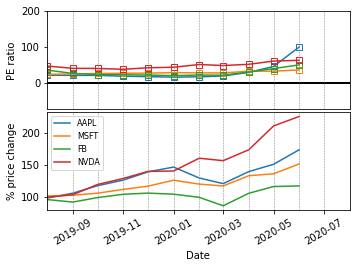

In [14]:
finalDate = dt(2020,7,1)
plt.figure(figsize=(5,3.5), facecolor='white')
ax1 = plt.axes([0.15, 0.2, 0.84, 0.39])
ax2 = plt.axes([0.15, 0.6, 0.84, 0.39])
for ticker in ['aapl', 'msft', 'fb', 'nvda']:
    
    result = getPEandVolume(ticker, finalDate)
    if result is None:
        continue
    dates, pe, p, v = zip(*result)
    
    ax2.plot(dates, pe, 's-', mfc='None', label=ticker.upper())
    ax1.plot(dates, 100*np.array(p)/p[-1], '-', label=ticker.upper())
    
    

ax1.set_xlim(( dt(2019,8,1), dt(2020,8,1) ))
ax2.set_xlim(( dt(2019,8,1), dt(2020,8,1) ))
ax2.set_ylim([-75, 200])
ax2.set_xticks([])

plt.sca(ax1)
plt.xticks(rotation=30)


ax2.axhline(0, color='k', lw=2)

for i in range(12):
    ax1.axvline( dt(2019,i+1,1), color=(0.5, 0.5, 0.5), ls='--', lw=0.5 )
    ax2.axvline( dt(2019,i+1,1), color=(0.5, 0.5, 0.5), ls='--', lw=0.5 )
    ax1.axvline( dt(2020,i+1,1), color=(0.5, 0.5, 0.5), ls='--', lw=0.5 )
    ax2.axvline( dt(2020,i+1,1), color=(0.5, 0.5, 0.5), ls='--', lw=0.5 )
    
    
ax1.set_ylabel('% price change', fontsize=10)
ax1.set_xlabel('Date', fontsize=10)
ax2.set_ylabel('PE ratio', fontsize=10)
plt.legend(fontsize=8, loc='upper left')
plt.savefig('img/techPE.png', dpi=300)
plt.show()
plt.close()

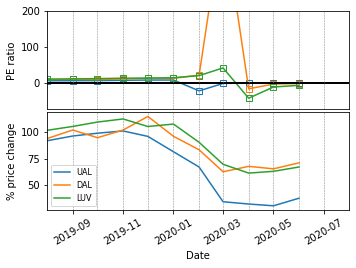

In [15]:
plt.figure(figsize=(5,3.5), facecolor='white')
ax1 = plt.axes([0.15, 0.2, 0.84, 0.39])
ax2 = plt.axes([0.15, 0.6, 0.84, 0.39])
for ticker in ['ual', 'dal', 'luv']:
    
    result = getPEandVolume(ticker, finalDate)
    if result is None:
        continue
    dates, pe, p, v = zip(*result)
    
    ax2.plot(dates, pe, 's-', mfc='None', label=ticker.upper())
    ax1.plot(dates, 100*np.array(p)/p[-1], '-', label=ticker.upper())
    
    

ax1.set_xlim(( dt(2019,8,1), dt(2020,8,1) ))
ax2.set_xlim(( dt(2019,8,1), dt(2020,8,1) ))
ax2.set_ylim([-75, 200])
ax2.set_xticks([])

plt.sca(ax1)
plt.xticks(rotation=30)


ax2.axhline(0, color='k', lw=2)

for i in range(12):
    ax1.axvline( dt(2019,i+1,1), color=(0.5, 0.5, 0.5), ls='--', lw=0.5 )
    ax2.axvline( dt(2019,i+1,1), color=(0.5, 0.5, 0.5), ls='--', lw=0.5 )
    ax1.axvline( dt(2020,i+1,1), color=(0.5, 0.5, 0.5), ls='--', lw=0.5 )
    ax2.axvline( dt(2020,i+1,1), color=(0.5, 0.5, 0.5), ls='--', lw=0.5 )
    
    
ax1.set_ylabel('% price change', fontsize=10)
ax1.set_xlabel('Date', fontsize=10)
ax2.set_ylabel('PE ratio', fontsize=10)
plt.legend(fontsize=8, loc='lower left')
plt.savefig('img/airPE.png', dpi=300)
plt.show()
plt.close()

In [16]:
def plotCompanyData(tickers, sector, finalDate=None):
    
    plt.figure(figsize=(5,3.5), facecolor='white')
    ax1 = plt.axes([0.15, 0.2, 0.84, 0.34])
    ax2 = plt.axes([0.15, 0.55, 0.84, 0.34])
    
    allPEs     = []
    allPrices  = []
    allVolumes = []
    
    for ticker in tickers:
        
        try:
            result = getPEandVolume(ticker, finalDate=finalDate)
            if result is None:
                continue
            dates, pe, p, v = zip(*result)
            allPEs.append( pe )
            allPrices.append( 100*np.array(p)/p[-1] )
            allVolumes.append( v )

            ax2.plot(dates, pe, 's-', mfc='None', label=ticker, 
                     mec=(0.5,0.5,0.5), color=(0.5,0.5,0.5), alpha=0.1)
            ax1.plot(dates, np.array(p)*100/p[-1], '-', label=ticker, 
                     mec=(0.5,0.5,0.5), color=(0.5,0.5,0.5), alpha=0.1)
            
        except Exception as e:
            logger.error(f'Unable to plot data for {ticker}: {e}')


    allPEs     = np.array(allPEs)
    allPrices  = np.array(allPrices)
    allVolumes = np.array( allVolumes )
    
    allPEs     = (allPEs * allVolumes).sum(axis=0)
    allPrices  = (allPrices * allVolumes).sum(axis=0)
    
    allVolumes = allVolumes.sum(axis=0)
    allPEs     = allPEs/allVolumes
    allPrices  = allPrices/allVolumes
    
    allPEs = allPEs.clip(-1000, 1000)
    
    print(allPEs)
    
    
    ax1.plot(dates, allPrices, 's-', mfc='red', color='red', label=ticker)
    ax2.plot(dates, allPEs, 's-', mfc='red', color='red', label=ticker)
    
    ax1.set_xlim(( dt(2019,4,1), dt(2020,7,1) ))
    ax2.set_xlim(( dt(2019,4,1), dt(2020,7,1) ))
    
    ax2.set_ylim([-100, 100])
    ax2.set_xticks([])
    ax1.set_xticks([
        dt(2019,5,1), dt(2019,8,1), dt(2019,11,1),
        dt(2020,2,1), dt(2020,5,1)
    ])
    
    plt.sca(ax1)
    plt.xticks(rotation=30)
    
    ax2.axhline(0, lw=2, color='k')

    for i in range(12):
        ax1.axvline( dt(2019,i+1,1), color=(0.5, 0.5, 0.5), ls='--', lw=0.5 )
        ax2.axvline( dt(2019,i+1,1), color=(0.5, 0.5, 0.5), ls='--', lw=0.5 )
        ax1.axvline( dt(2020,i+1,1), color=(0.5, 0.5, 0.5), ls='--', lw=0.5 )
        ax2.axvline( dt(2020,i+1,1), color=(0.5, 0.5, 0.5), ls='--', lw=0.5 )

    ax1.set_ylabel('% price change')
    ax2.set_ylabel('PE ratio')
    plt.figtext( 0.42 + 0.15, 0.9, sector, ha='center')
    plt.savefig(f'img/{sector}.png', dpi=300)
    plt.show()
    plt.close()
    
    return

[ 13.25208758  12.00834272  19.91090894  55.32865907  19.5170917
  66.89305252  20.4733213   20.88258717  17.370513    17.07006238
  10.20320842 -50.33812999]


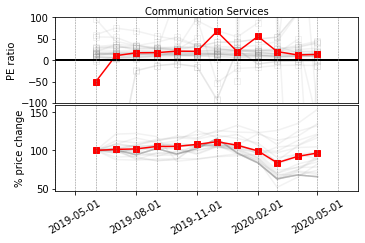

2020-08-14 00:06:24,618 - financeMacroFactors.companies.marketWatchData.extractQuarterlyData - ERROR - Empty data provided. An empty list is returned
2020-08-14 00:06:24,618 - financeMacroFactors.companies.marketWatchData.extractQuarterlyData - ERROR - Empty data provided. An empty list is returned


[-176.48435531   18.55971142   19.91490185    3.57260737   10.8958214
   19.43849481   11.19104339   14.98971089   15.04026619   28.58044763
   25.54727731    5.05568419]


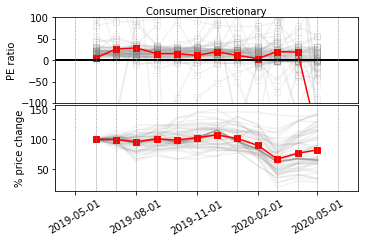

[ 11.22423196 -28.62547109  20.60228213  18.15398928  19.77352215
  39.70665839  21.8227137   18.15102092  19.59860929  -1.32729327
  14.84019151  13.92824585]


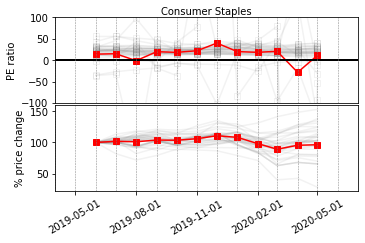

[   -8.15803124    -4.1229838  -1000.            -2.31601582
     9.99027914    12.13861158     2.6287092     16.85002973
    19.91255712   595.67480605    -7.51180061    90.46566405]


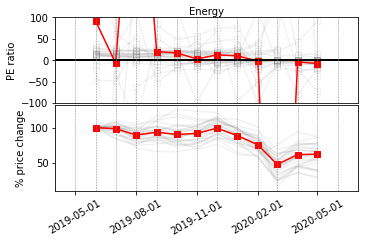

[17.61978812 79.54935804 12.94269721 13.37672548 13.41840309 13.77041218
 19.7231425  12.90253928 14.56086287 11.3892642  12.09698703 11.44895339]


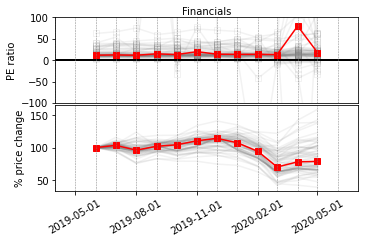

[ 11.72770389  61.32107152  19.45359685  28.46551499 -10.68835534
  16.42714005  31.4340508   24.85191205  23.41465316  27.48739486
  25.72931207  22.46967901]


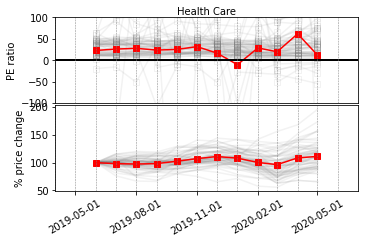

<ipython-input-13-ad3011935ad3>:59: RuntimeWarning: divide by zero encountered in double_scalars
  result = [(d, p/epsDict[d], p, sharesDict[d])  for d, p in zip(datesP, pricesP) if d in dates ]
2020-08-14 00:06:27,180 - financeMacroFactors.companies.marketWatchData.extractQuarterlyData - ERROR - Empty data provided. An empty list is returned
2020-08-14 00:06:27,180 - financeMacroFactors.companies.marketWatchData.extractQuarterlyData - ERROR - Empty data provided. An empty list is returned
2020-08-14 00:06:27,211 - financeMacroFactors.companies.marketWatchData.extractYearlyData - ERROR - Unable to extract [EPS (Diluted)] from the data
2020-08-14 00:06:27,211 - financeMacroFactors.companies.marketWatchData.extractYearlyData - ERROR - Check to see whether the information you provided is correct
2020-08-14 00:06:27,212 - financeMacroFactors.companies.marketWatchData.extractQuarterlyData - ERROR - Empty data provided. An empty list is returned
2020-08-14 00:06:27,212 - financeMacroFactors.

Unable to convert [] to date: list index out of range
Unable to convert [] to date: list index out of range
[  28.71496776 1000.           24.02024017   26.2111168    22.27359155
   54.52108637    8.22273399   16.77682274    8.77906603    1.70620025
  -63.27957989  -72.64936452]


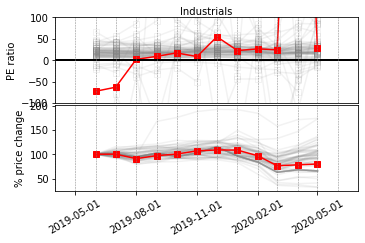

[16.4392829  62.49050455 10.9130635  17.40861012 34.57819613 17.81700584
 26.3924458  19.72284257 38.15284459 31.64322875 34.24055581 22.96696513]


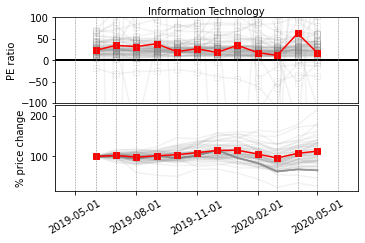

2020-08-14 00:06:28,376 - financeMacroFactors.companies.marketWatchData.extractYearlyData - ERROR - Unable to extract [EPS (Diluted)] from the data
2020-08-14 00:06:28,376 - financeMacroFactors.companies.marketWatchData.extractYearlyData - ERROR - Check to see whether the information you provided is correct
2020-08-14 00:06:28,376 - financeMacroFactors.companies.marketWatchData.extractQuarterlyData - ERROR - Empty data provided. An empty list is returned
2020-08-14 00:06:28,376 - financeMacroFactors.getPEandVolume - ERROR - Unable to generate PE data for [AMCR]: not enough values to unpack (expected 2, got 0)


Unable to convert [] to date: list index out of range
[ -32.66777994   23.37771501    3.72831079   -0.87307619  272.82612399
  -76.10836304  -25.03704245   -6.74854195    0.89387838  -23.67316214
 -100.82852719  187.68789084]


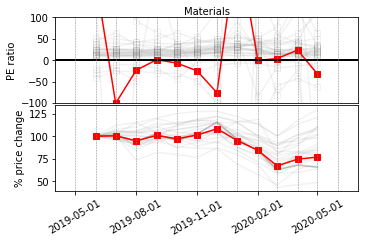

2020-08-14 00:06:28,820 - financeMacroFactors.companies.marketWatchData.extractQuarterlyData - ERROR - Empty data provided. An empty list is returned
2020-08-14 00:06:28,821 - financeMacroFactors.companies.marketWatchData.extractQuarterlyData - ERROR - Empty data provided. An empty list is returned


[-11.43250885  78.05009027  15.65393594 381.04744863  24.94175171
  71.38289331  28.57856287  73.690397    31.36966859  31.79450302
  24.37404451  14.80888628]


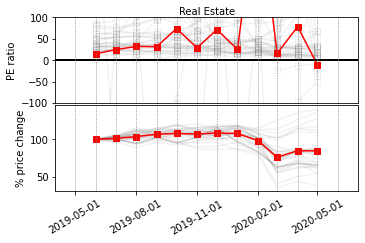

[77.79065689 69.11422414 64.10204276 67.91837367 70.36521739 68.2200692
 69.05235385 67.13       70.20348837 73.94010025 72.921875   65.96865193]


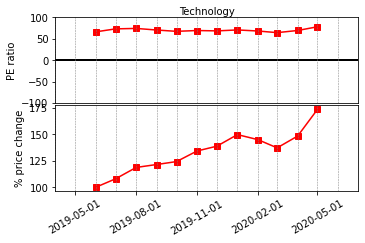

[ 17.56871443  31.71068587  11.47460818 -36.78362012  22.66636343
 325.48214078  19.80070678   6.44569188  21.46548477  25.02666365
  63.61222734  19.14167708]


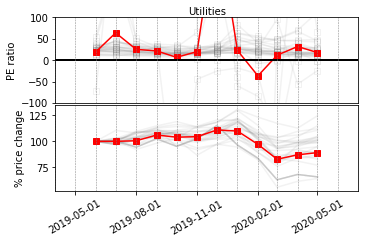

In [17]:

finalDate = dt(2020,6,1)

companies = json.load(open('data/companies.json'))
companies = sorted(companies, key=lambda m: m['GICS Sector'])

for sector, v in it.groupby(companies, key=lambda m: m['GICS Sector']):
    tickers = [m['Symbol'] for m in v]
    plotCompanyData(tickers, sector, finalDate)


2020-08-14 00:07:18,918 - financeMacroFactors.companies.marketWatchData.extractQuarterlyData - ERROR - Empty data provided. An empty list is returned
2020-08-14 00:07:18,918 - financeMacroFactors.companies.marketWatchData.extractQuarterlyData - ERROR - Empty data provided. An empty list is returned
<ipython-input-13-ad3011935ad3>:59: RuntimeWarning: divide by zero encountered in double_scalars
  result = [(d, p/epsDict[d], p, sharesDict[d])  for d, p in zip(datesP, pricesP) if d in dates ]
2020-08-14 00:07:19,468 - financeMacroFactors.companies.marketWatchData.extractQuarterlyData - ERROR - Empty data provided. An empty list is returned
2020-08-14 00:07:19,469 - financeMacroFactors.companies.marketWatchData.extractQuarterlyData - ERROR - Empty data provided. An empty list is returned
2020-08-14 00:07:19,497 - financeMacroFactors.companies.marketWatchData.extractYearlyData - ERROR - Unable to extract [EPS (Diluted)] from the data
2020-08-14 00:07:19,498 - financeMacroFactors.companies.m

Unable to convert [] to date: list index out of range
Unable to convert [] to date: list index out of range


2020-08-14 00:07:19,751 - financeMacroFactors.companies.marketWatchData.extractYearlyData - ERROR - Unable to extract [EPS (Diluted)] from the data
2020-08-14 00:07:19,752 - financeMacroFactors.companies.marketWatchData.extractYearlyData - ERROR - Check to see whether the information you provided is correct
2020-08-14 00:07:19,752 - financeMacroFactors.companies.marketWatchData.extractQuarterlyData - ERROR - Empty data provided. An empty list is returned
2020-08-14 00:07:19,752 - financeMacroFactors.getPEandVolume - ERROR - Unable to generate PE data for [AMCR]: not enough values to unpack (expected 2, got 0)
2020-08-14 00:07:19,879 - financeMacroFactors.companies.marketWatchData.extractQuarterlyData - ERROR - Empty data provided. An empty list is returned
2020-08-14 00:07:19,879 - financeMacroFactors.companies.marketWatchData.extractQuarterlyData - ERROR - Empty data provided. An empty list is returned


Unable to convert [] to date: list index out of range
[  -3.73105946 1000.          -59.23355811   28.648208     24.70232629
   38.70210503   18.36785262   18.57498966   20.68915925   57.78872338
    9.10470235   11.16247099]


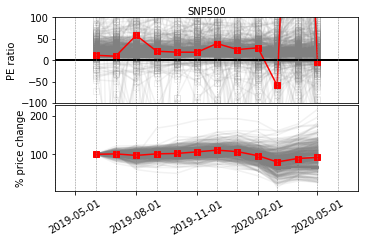

In [18]:

finalDate = dt(2020,6,1)

companies = json.load(open('data/companies.json'))
companies = sorted(companies, key=lambda m: m['GICS Sector'])
tickers = [m['Symbol'] for m in companies]
plotCompanyData(tickers, 'SNP500', finalDate)